# 风管模型第四次作业

股票市场的走势是一个国家经济状况的“晴雨表”。长久以来，此领域一直是众多学者的研究重点。目前，预测股票价格走势的方法多种多样，但是均存在对股票价格的波动拟合效果较差、预测精度有限等问题。时间序列模型具有应用范围广、限制要求少、短期预测准确率高等优点，借此，它成为了金融预测领域较受欢迎的预测模型之一。

时间序列分析是一种主要用于描述和探究某一现象随时间的发展如何变化的分析方法。时间序列是同一种现象在不同时间上的相继观察值排列而成的一组数字序列。人们运用时间序列的历史数据，揭示现象随时间变化的规律并将这种规律延伸到未来，从而对该现象的未来做出预测。

本文运用时间序列分析方法，使用LN、AR、ARCH、GARCH、RSLN-2五个模型对样本数据进行拟合，计算对数似然函数的最大值以及AIC和SBC，比较不同模型的拟合效果，并对沪深300指数未来的走势进行预判。

<Axes: ylabel='Density'>

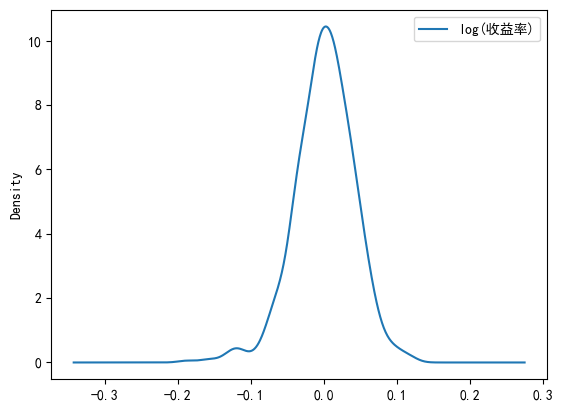

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# print("importing done")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
result = {}
df = (
    pd.read_excel("./lib/创业板指.xlsx", index_col=2, skipfooter=2)
    .sort_index()
    .drop(columns=["代码", "名称"])
)
df = df.apply(
    lambda x: x.str.replace(",", "").astype(float) if x.dtype == "object" else x
)
df.index = pd.to_datetime(df.index)
df["weeknum"] = df.index.map(lambda x: str(x.year) + "-" + str(x.isocalendar().week))
df = df.sort_index()
df["log(收益率)"] = (df["收盘价(元)"] / df["收盘价(元)"].shift(1)).dropna().apply(np.log)
df[["log(收益率)"]].plot(kind="kde")

## 第一题

### LN 模型

我们依据<cite data-cite="wang2020corrected">Wang(2020)</cite> 提出的算法，对 Lognormal 模型进行最大似然估计，即

$$
\log(L) = -\sum_{i=1}^n\log x_i-n\log\sigma-\frac{n}{2}\log 2\pi - \sum_{i=11^n}\frac{(\log x_i-\mu)^2}{2\sigma^2}
$$

采用样本均值 $\hat\mu$ 和样本方差 $\hat\sigma^2$ 代入计算 $AIC$、$SBC$，得到的结果如下表所示

In [49]:
# df["weeknum"] = df.index.map(lambda x: str(x.year) + "-" + str(x.isocalendar().week))
# df = df.drop_duplicates(subset="weeknum", keep="last")
log = (df["收盘价(元)"] / df["收盘价(元)"].shift(1)).dropna().apply(np.log)
mu = log.mean()
sigma = log.std()
likelyhood_ln = log.apply(
    lambda x: -np.log(sigma) - np.log(2 * np.pi) / 2 - (x - mu) ** 2 / (2 * sigma**2)
).sum()
k, logl = 2, likelyhood_ln
result["LN"] = {
    "k": k,
    "log(L)": logl,
    "AIC": logl - k,
    "SBC": logl - k * np.log(log.shape[0]) / 2,
}
pd.DataFrame(result).T

,AIC,SBC,k,log(L)
LN,1180.436168,1175.934878,2.0,1182.436168


### AR(1) 模型

自回归模型（AR）是最简单的时间序列处理方法，对LogNormal的改进在于考虑了变量之间的相关性，用过去随机变量的情况来描述未来该随机变量的取值。在自回归模型假设下，随机变量的取值总会向长期均值靠拢。我们选择一阶自回归模型对样本数据进行拟合，函数表达式为 
$$Y_t=\mu+\alpha(Y_{t-1}-\mu)+\sigma\varepsilon_t$$
其中 $\alpha\in(-1,1)$ ，$\varepsilon_t$ 为相互独立且符合标准正态分布的白噪声过程。

In [50]:
model = ARIMA(log.values, order=(1, 0, 0))
AR1 = model.fit()
k, logl = 3, AR1.llf
result["AR(1)"] = {
    "k":k,
    "log(L)": logl,
    "AIC": logl - k,
    "SBC": logl - k * np.log(log.shape[0]) / 2,
}
print(AR1.summary())
pd.DataFrame(result).T

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  666
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1183.091
Date:                Wed, 07 Jun 2023   AIC                          -2360.182
Time:                        16:46:57   BIC                          -2346.678
Sample:                             0   HQIC                         -2354.950
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.633      0.527      -0.002       0.004
ar.L1          0.0442      0.031      1.450      0.147      -0.016       0.104
sigma2         0.0017   7.24e-05     23.157      0.0

,k,log(L),AIC,SBC
LN,2.0,1182.436168,1180.436168,1175.934878
AR(1),3.0,1183.090866,1180.090866,1173.338932


自回归方法的优点是所需资料不多，可用自身变数数列来进行预测。但是这种方法受到一定的限制：必须具有自相关，自相关系数是关键。如果自相关系数(R)小于0.5，则不宜采用，否则预测结果极不准确。自回归只能适用于预测与自身前期相关的经济现象，即受自身历史因素影响较大的经济现象，如矿的开采量，各种自然资源产量等；对于受社会因素影响较大的经济现象，不宜采用自回归，而应改采可纳入其他变数的向量自回归模型。

### ARCH 模型

ARCH模型即自回归条件异方差模型，是一种用来处理时间序列的模型。在股票中，ARCH可以用来预测股票的波动率，从而控制风险。粗略地说，该模型将当前一切可利用信息作为条件，并采用某种自回归形式来刻画方差的变异，对于一个时间序列而言，在不同时刻可利用的信息不同，而相应的条件方差也不同，利用ARCH模型，可以刻画出随时间而变异的条件方差。ARCH模型解决了LogNormal和AR被诟病的波动率恒定问题。这里我们同样使用一阶条件异方差模型对样本数据进行拟合，函数表达式为 $$Y_t=\mu+\sigma_t \varepsilon_t$$ 
其中 $\sigma_t^2=a_0+a_1(Y_(t-1)-\mu)^2$。

In [51]:
arch = arch_model(log, p=1, q=0, rescale=False).fit(update_freq=0)
k, logl = 3, arch.loglikelihood
print(arch.summary())
result["ARCH"] = {
    "k":k,
    "log(L)": logl,
    "AIC": logl - k,
    "SBC": logl - k * np.log(log.shape[0]) / 2,
}
pd.DataFrame(result).T

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.4776946315305
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 收盘价(元)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1160.48
Distribution:                  Normal   AIC:                          -2314.96
Method:            Maximum Likelihood   BIC:                          -2301.45
                                        No. Observations:                  666
Date:                Wed, Jun 07 2023   Df Residuals:                      665
Time:                        16:46:57   Df Model:                            1
                                  Mean Model                                 
  

,k,log(L),AIC,SBC
LN,2.0,1182.436168,1180.436168,1175.934878
AR(1),3.0,1183.090866,1180.090866,1173.338932
ARCH,3.0,1160.477695,1157.477695,1150.725760


### GARCH 模型

GARCH模型，即广义ARCH模型，它是对ARCH模型的进一步扩展。它同时考虑了序列相关和条件方差，对误差的方差进行了进一步建模，具有更强的灵活性。本文选择 $GARCH(1,1)$ 模型对历史数据进行拟合。

根据拟合结果可知，对数似然函数值为 7557.05，AIC为 7553.0492，SBC为 7541.0919。

In [52]:
garch = arch_model(log, p=1, q=1, rescale=False).fit(update_freq=0)
k, logl = 4, garch.loglikelihood
print(garch.summary())
result["GARCH"] = {
    "k":k,
    "log(L)": logl,
    "AIC": logl - k,
    "SBC": logl - k * np.log(log.shape[0]) / 2,
}
pd.DataFrame(result).T

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1228.8837666021368
            Iterations: 14
            Function evaluations: 101
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 收盘价(元)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1228.88
Distribution:                  Normal   AIC:                          -2449.77
Method:            Maximum Likelihood   BIC:                          -2431.76
                                        No. Observations:                  666
Date:                Wed, Jun 07 2023   Df Residuals:                      665
Time:                        16:46:58   Df Model:                            1
                                  Mean Model                                 

,k,log(L),AIC,SBC
LN,2.0,1182.436168,1180.436168,1175.934878
AR(1),3.0,1183.090866,1180.090866,1173.338932
ARCH,3.0,1160.477695,1157.477695,1150.725760
GARCH,4.0,1228.883767,1224.883767,1215.881187


### RSLN-2

RSLN 模型本质是马尔可夫状态转移模型，因而我们参考[statsmodels 文档](https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html)，令两 regime 分布异方差，回归结果如下表，显示异方差的确存在(不同状态下的方差影响显著)。

同样，我们提取似然函数对数，并计算 $AIC$、$SBC$

In [53]:
rsln = MarkovRegression(log.values, 2, switching_variance=True).fit()  # 异方差
k, logl = 6, rsln.llf
print(rsln.summary())
result["RSLN-2"] = {
    "k": k,
    "log(L)": logl,
    "AIC": logl - k,
    "SBC": logl - k * np.log(log.shape[0]) / 2,
}
pd.DataFrame(result).T

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  666
Model:               MarkovRegression   Log Likelihood                1220.002
Date:                Wed, 07 Jun 2023   AIC                          -2428.005
Time:                        16:46:58   BIC                          -2400.997
Sample:                             0   HQIC                         -2417.541
                                - 666                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      0.935      0.350      -0.002       0.004
sigma2         0.0012   8.76e-05     14.079      0.0

,k,log(L),AIC,SBC
LN,2.0,1182.436168,1180.436168,1175.934878
AR(1),3.0,1183.090866,1180.090866,1173.338932
ARCH,3.0,1160.477695,1157.477695,1150.725760
GARCH,4.0,1228.883767,1224.883767,1215.881187
RSLN-2,6.0,1220.002313,1214.002313,1200.498444


### 综合比较

不同似然函数对比采用 $\chi^2$ 检验，以 lognormal 模型为基准进行 LRT 检验，结果如下表显示。综合似然函数最大值、$AIC$、$SBC$ 与 $LRT$ 检验值，GARCH 模型的似然函数、$AIC$、$SBC$ 最大，且相较于 lognormal 模型效果提升显著。

In [54]:
# basemodel = "LN"
# for model in result:
#     if model == basemodel:
#         continue
#     result[model]["LRT"] = chi2.sf(
#         result[model]["log(L)"] - result[basemodel]["log(L)"],
#         result[model]["k"] - result[basemodel]["k"],
#     )
pd.DataFrame(result).T

,k,log(L),AIC,SBC
LN,2.0,1182.436168,1180.436168,1175.934878
AR(1),3.0,1183.090866,1180.090866,1173.338932
ARCH,3.0,1160.477695,1157.477695,1150.725760
GARCH,4.0,1228.883767,1224.883767,1215.881187
RSLN-2,6.0,1220.002313,1214.002313,1200.498444


## 第二题

对比五个模型的SBC和AIC数值，我们认为ARCH模型是最优的。因此，下文选择ARCH模型来估计投资组合的未来走势与市场风险。

我们使用VaR和ES来描述模拟分布的市场风险，分别探讨了置信水平为99%、95%和90%三种情况，最终得到使用GARCH模型进行蒙特卡洛模拟时，99%置信水平下的单周收益率VaR=-22.05%，对应的ES=-26.16%；95%置信水平下的单周收益率VaR=-15.17%，对应的ES=-19.54%；90%置信水平下的单周收益率VaR=-11.80%，对应的ES=-16.46%。

In [55]:
monte_carlo = {}
np.random.RandomState(42)
cases = 10000
for case in range(cases):
    if (case*10) % cases == 0:
        print("simulating",case/cases*100, "%")
    sim_model = arch_model(None, p=1, q=1)
    simulation = sim_model.simulate(garch.params, 26)
    monte_carlo[case] = np.prod(1 + simulation["data"])

simulating 0.0 %
simulating 10.0 %
simulating 20.0 %
simulating 30.0 %
simulating 40.0 %
simulating 50.0 %
simulating 60.0 %
simulating 70.0 %
simulating 80.0 %
simulating 90.0 %


In [56]:
monte_carlo = pd.Series(monte_carlo)
var = pd.Series(monte_carlo).quantile([0.01, 0.05, 0.1])
es = var.apply(lambda x: monte_carlo[monte_carlo < x].mean())
pd.DataFrame({"es": es - 1, "var": var - 1})

,es,var
0.01,-0.499970,-0.427457
0.05,-0.379925,-0.300438
0.10,-0.323582,-0.241536
